In [1]:
import torchaudio
import pathlib
import pandas as pd
import librosa
import numpy as np
import utils
import importlib
import torch
import torch.nn as nn
from torch.utils.data import random_split
import wandb
import torch.nn.functional as F
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# classes = ['Alarm_bell_ringing', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush']
classes = ["Cat", "Dog"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = {
    "sample_rate": 44100,
    "n_mels": 64,
    "n_fft": 1024, 
    "hop_len": 512,
    "top_db": 80,
    "n_mfcc": 64,
    "classes": classes,
    "data_path": "../scaper/soundscapes/train",
    "duration": 10000
}

df, classes = utils.get_dataset_dataframe(config["data_path"])
dataset = utils.SoundDataSet(df, melspec=False, **config)
# Train / Val Split

num_items = len(dataset)
print(num_items)
num_train = round(num_items * 0.9)
num_val = num_items - num_train
batch_size = 100

train_ds, val_ds = random_split(dataset, [num_train, num_val])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

  0%|          | 0/700 [00:00<?, ?it/s]

700


In [3]:
sig, spec, class_ids, sr, path = dataset.get_index(1)

In [4]:
print(class_ids, sr, path)

[0 1] 44100 ../scaper/soundscapes/train/soundscape_unimodal55.wav


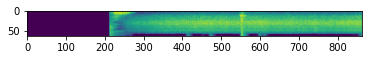

In [5]:
plt.imshow(spec.squeeze())

In [6]:
class minimal_model(nn.Module):
    def __init__(self, config):
        super(minimal_model, self).__init__()
        
        self.spec = torchaudio.transforms.Spectrogram(
            n_fft = config["n_fft"],
            power = 2, # 1 is energy, 2 is power
            normalized = True
        )
        self.melspec = torchaudio.transforms.MelSpectrogram(
                    sample_rate = config["sample_rate"],
                    n_fft = config["n_fft"],
                    win_length = config["n_fft"]//2,
                    hop_length = config["hop_len"],
                    n_mels = config["n_mels"],
                    normalized = True
                )
        self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype = "power", top_db = config["top_db"])
        
        self.bn0 = nn.BatchNorm2d(1)
        self.conv0 = nn.Conv2d(1, 64, (3,3))
        self.conv1 = nn.Conv2d(64, 256, (3,3))
        self.conv2 = nn.Conv2d(256, 256, (3,3))
        self.fc = nn.Linear(23552, 2)
        
        
        
    def forward(self, input):
        x = self.melspec(input)
        x = self.amp_to_db(x)
        
        x = self.bn0(x)
        x = self.conv0(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = nn.Dropout(p = 0.2)(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (3,3))
        x = nn.Dropout(p = 0.2)(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (3,3))
        x = nn.Dropout(p = 0.2)(x)
        
        x = torch.flatten(x, 1)
        out = self.fc(x)
        
#         out = torch.sigmoid(x)
        
        return out
        

In [13]:
model = minimal_model(config)

In [14]:
model.to(device)

minimal_model(
  (spec): Spectrogram()
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amp_to_db): AmplitudeToDB()
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=23552, out_features=2, bias=True)
)

In [15]:
def train(model, train_dl, num_epochs, classes):
    wandb.init(project='endomic', entity='maddonix')
    config = wandb.config
    
    criterion = nn.BCEWithLogitsLoss() # nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    n_classes = len(classes)

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = np.zeros((n_classes))
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            model.train()
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.type_as(outputs))
            loss.backward()
#             print(loss)
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted classes with threshold > 0.5
            outputs[outputs>0.5] = 1
            outputs[outputs<=0.5] = 0
            prediction = outputs
            
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum(axis = 0).cpu().numpy()
            total_prediction += prediction.shape[0]

#             if i % 10 == 0 and i > 0:    # print every 10 mini-batches
#                 print(f'Epoch: {epoch}, iteration: {i} loss: {running_loss / i}')

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/(total_prediction*n_classes)
        acc_dict ={_: acc[i] for i, _ in enumerate(classes)}
#         model.eval()
#         val_loss, val_acc_dict = evaluate(model, val_dl, classes, criterion)
        wandb.log({
            "train_loss": loss,
            "train_acc": acc_dict,
#             "val_loss": val_loss,
#             "val_acc": val_acc_dict
        })        
        
        print(f'Epoch: {epoch}')
        print(f'Train: Loss: {avg_loss}, Accuracy: {acc}')
#         print(f'Val: Loss: {val_loss}, Accuracy: {val_acc_dict}')
        

    print('Finished Training')

In [16]:
train(model, train_dl, 1000, classes)

train_loss,0.53961
_runtime,16
_timestamp,1619096310
_step,7


train_loss,▅▃▁▄▄▄█▆
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


Epoch: 0
Train: Loss: 0.5979890397616795, Accuracy: [0.37857143 0.38333333]
Epoch: 1
Train: Loss: 0.5595464110374451, Accuracy: [0.37857143 0.38333333]
Epoch: 2
Train: Loss: 0.5434355352606092, Accuracy: [0.37857143 0.38333333]
Epoch: 3
Train: Loss: 0.546835584299905, Accuracy: [0.37857143 0.38333333]
Epoch: 4
Train: Loss: 0.540847625051226, Accuracy: [0.37857143 0.38333333]
Epoch: 5
Train: Loss: 0.5362636872700283, Accuracy: [0.37857143 0.38333333]
Epoch: 6
Train: Loss: 0.5395576570715223, Accuracy: [0.37857143 0.38333333]
Epoch: 7
Train: Loss: 0.5478473135403225, Accuracy: [0.37857143 0.38333333]
Epoch: 8
Train: Loss: 0.5476338182176862, Accuracy: [0.37857143 0.38333333]
Epoch: 9
Train: Loss: 0.5347221664019993, Accuracy: [0.37857143 0.38333333]
Epoch: 10
Train: Loss: 0.5442323684692383, Accuracy: [0.37857143 0.38333333]
Epoch: 11
Train: Loss: 0.5410639217921666, Accuracy: [0.37857143 0.38333333]
Epoch: 12
Train: Loss: 0.5257597608225686, Accuracy: [0.37857143 0.38333333]
Epoch: 13
T

KeyboardInterrupt: 

In [ ]:
# classes = ['Alarm_bell_ringing', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush']
classes = ["Cat", "Dog"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = {
    "sample_rate": 44100,
    "n_mels": 64,
    "n_fft": 1024, 
    "hop_len": 512,
    "top_db": 80,
    "n_mfcc": 64,
    "classes": classes,
    "data_path": "../scaper/soundscapes/train",
    "duration": 10000
}

df, classes = utils.get_dataset_dataframe(config["data_path"])
dataset = utils.SoundDataSet(df, **config)
# Train / Val Split

num_items = len(dataset)
print(num_items)
num_train = round(num_items * 0.9)
num_val = num_items - num_train
batch_size = 10

train_ds, val_ds = random_split(dataset, [num_train, num_val])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
model.fc = nn.Linear(fc.in_features, 2, bias = True)

In [ ]:
# Redefine input channels:
model.conv1=nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], padding=model.conv1.padding[0])


In [ ]:
num_epochs = 200
base_lr = 0.001

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = base_lr, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = num_epochs//3, gamma = 0.1)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
wandb.init(project='endomic', entity='maddonix')
config = wandb.config

In [ ]:
def plot_signal(signal, title, cmap=None):
    fig = plt.figure()
    if signal.ndim == 1:
        plt.plot(signal)
    else:
        plt.imshow(signal, cmap=cmap)    
    plt.title(title)

In [ ]:
def train(model, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.type_as(outputs))
        loss.backward()
        optimizer.step()
        
        iteration = epoch * len(train_loader) + batch_idx
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(inputs), len(train_loader.dataset), 
                          100. * batch_idx / len(train_loader), loss))
            wandb.log({
                "train_loss": loss,
                "learning rate": optimizer.param_groups[0]['lr']
            }) 
                
        
        if batch_idx % debug_interval == 0:    # report debug image every "debug_interval" mini-batches
            for n, (inp, pred, label) in enumerate(zip(inputs, predicted, labels)):
                series = 'label_{}_pred_{}'.format(classes[label.cpu()], classes[pred.cpu()])
                print('Train MelSpectrogram samples/{}_{}_{}'.format(batch_idx, n, series))
                plot_signal(inp.cpu().numpy().squeeze(), series, 'hot')


In [ ]:
def test(model, epoch):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for idx, (sounds, sample_rate, inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            prediction = outputs.copy()
            prediction[prediction>0.5] = 1
            prediction[prediction<=0.5] = 0
            
            # Count of predictions that matched the target label
            c += (prediction == labels).sum(axis = 0).cpu().numpy()

            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1
        
            iteration = (epoch + 1) * len(train_loader)
            if idx % debug_interval == 0:    # report debug image every "debug_interval" mini-batches
                for n, (sound, inp, pred, label) in enumerate(zip(sounds, inputs, predicted, labels)):
                    series = 'label_{}_pred_{}'.format(classes[label.cpu()], classes[pred.cpu()])
                    print('Test audio samples/{}_{}_{}'.format(idx, n, series), 
                                                 sound, iteration, int(sample_rate[n]))
                    print('Test MelSpectrogram samples/{}_{}_{}'.format(idx, n, series))
                    plot_signal(inp.cpu().numpy().squeeze(), series, 'hot')

    total_accuracy = 100 * sum(class_correct)/sum(class_total)
    print('[Iteration {}] Accuracy on the {} test images: {}%\n'.format(epoch, sum(class_total), total_accuracy))
    wandb.log({
                "accuracy/total": total_accuracy
    })

In [ ]:
log_interval = 10
debug_interval = 25
for epoch in range(num_epochs):
    train(model, epoch)
    test(model, epoch)
    scheduler.step()